# Modelos Avanzados No Supervizados

Dataset: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

import umap

sns.set_style("whitegrid")

/home/keras/wordspaces/ml2_clases/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
customer_data_raw = pd.read_csv("../data/raw/Mall_Customers.csv")
customer_data_raw

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [4]:
customer_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## Software para el ejercicio

In [26]:
class UnsupervisedProcessor:
    def __init__(self, dataframe: pd.DataFrame, scaler, cluster_algorithm, dim_reduction_algorithm) -> None:
        self.original_data = dataframe.copy()
        self.scaler = scaler
        self.cluster_algorithm = cluster_algorithm
        self.features = None
        self.dim_reduction_algorithm = dim_reduction_algorithm
        self.cluster_Pipeline = Pipeline([
            ('scaler', self.scaler),
            ('clustering', self.cluster_algorithm)
        ])
        self.dim_reduction_pipeline = Pipeline([
            ('scaler', self.scaler),
            ('dim_reduction', self.dim_reduction_algorithm)
        ])
        self.processed_data = None

    def __process_clustering(self, features: list):
        data = self.original_data[features]
        self.cluster_Pipeline.fit(data)
        labels = self.cluster_Pipeline.named_steps['clustering'].labels_
        clustering_df = self.cluster_Pipeline.named_steps['scaler'].transform(data)

        clustering_df = pd.concat([
            self.original_data['CustomerID'],
            pd.DataFrame(clustering_df, columns= features),
            pd.DataFrame(labels, columns=['Cluster'])
        ], axis=1)

        return clustering_df

    def __process_dim_reduction(self, features: list):
        data = self.original_data[features]
        self.dim_reduction_pipeline.fit(data)
        dim_reduced_data = self.dim_reduction_pipeline.fit_transform(data)

        return pd.concat([
            self.original_data['CustomerID'],
            pd.DataFrame(dim_reduced_data, columns=[f'Component_{i+1}' for i in range(dim_reduced_data.shape[1])])
        ], axis=1)
    
    
    def run(self, features: list) -> pd.DataFrame:
        self.features = features
        _clustering_results = self.__process_clustering(features=features)
        _dim_reduction_results = self.__process_dim_reduction(features=features)
        self.processed_data = _clustering_results.merge(_dim_reduction_results, on='CustomerID')
        return self.processed_data


    def calculate_clustering_metrics(self) -> None:
        metrics = {
            "Silhouette Score": silhouette_score(self.original_data[self.features], self.processed_data['Cluster']),
            "Calinski-Harabasz Index": calinski_harabasz_score(self.original_data[self.features], self.processed_data['Cluster']),
            "Davies-Bouldin Index": davies_bouldin_score(self.original_data[self.features], self.processed_data['Cluster'])
        }

        print("--- Métricas del Clustering ---")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")
            
        self.plot_results()

    def plot_results(self) -> None:
        sns.scatterplot(data=self.processed_data, x='Component_1', y='Component_2', hue='Cluster', palette='Set2')
        plt.title('Clustering Results')
        

In [47]:
processor = UnsupervisedProcessor(
    dataframe=customer_data_raw, 
    scaler=StandardScaler(), 
    cluster_algorithm=DBSCAN(eps=0.4, min_samples=5),
    dim_reduction_algorithm=umap.UMAP(n_components=2)
)

--- Métricas del Clustering ---
Silhouette Score: 0.0587
Calinski-Harabasz Index: 14.9678
Davies-Bouldin Index: 1.9986


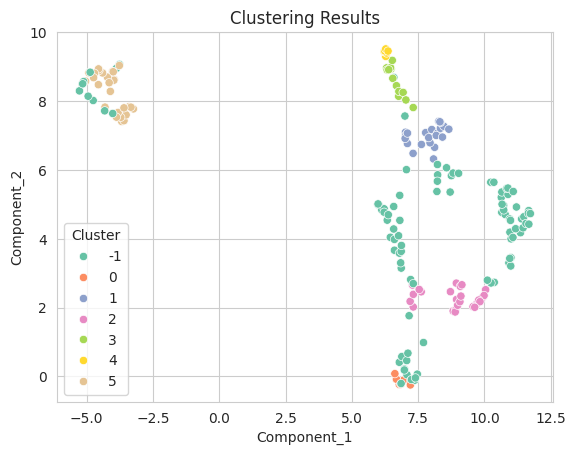

In [48]:
processed_data = processor.run(features=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
processor.calculate_clustering_metrics()